In [1]:
!pip install ftfy regex tqdm torch
!pip install git+https://github.com/openai/CLIP.git
!pip install pytorch-lightning

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-m8c4tutq
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-m8c4tutq
  Resolved https://github.com/openai/CLIP.git to commit b4ae44927b78d0093b556e3ce43cbdcff422017a


In [1]:
import clip
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from aliproduct_model import ALIPRODUCT_CLIP

In [3]:
!nvidia-smi

Mon Apr 25 11:22:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 510.60.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN X ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 33%   48C    P8    12W / 250W |      8MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN X ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   

In [4]:
class CONFIG:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample = False
    filter_sample = False
    custom_sample =True
    single_sample  = "00001_5417.jpg"
    with open("../clip/img_sample_to_test.txt","r") as f:
        custom_sample_list = f.readlines()
        custom_sample_list = [i.strip() for i in custom_sample_list]
    custom_label_list =[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]
print(f"Using device: {CONFIG.device}")

Using device: cuda


In [5]:
image_data_dir = "/home/ubuntu/Downloads/Auto-retail-syndata-release"
image_data_folder = "syn_image_train"
df = pd.read_csv("../clip/aicity4.csv")
df.head()

,Unnamed: 0,syn_image,label,label_name
0,0,00055_91621.jpg,55,Heavy Duty Forks
1,1,00079_67082.jpg,79,Nasal Strip
2,2,00008_96887.jpg,8,Bandaid Variety
3,3,00077_26117.jpg,77,Nasacort Allergy
4,4,00025_30398.jpg,25,Chocolate Fudge Poptart


In [6]:
x_train,x_test = train_test_split(df,random_state= 101,stratify=df["label"],test_size=0.2)

In [7]:
x_test.index

Int64Index([  2583,  20947,  21674,  94206,  63404,  97070,  49368,  43331,
             87923, 104281,
            ...
             70677,  30506,  45496,  45688,  90125,  36410,  19615,  36299,
            107485,  41658],
           dtype='int64', length=23300)

In [8]:
class AI_CITY_DATASET():
    def __init__(self,df,dir,folder,preprocess):
        self.df = df
        self.dir = dir
        self.folder = folder
        self.preprocess = preprocess
        self.z_shot_labels,self.z_shot_label_map = self.create_z_shot_labels(self.df["label_name"].unique(),self.df["label"].unique())
    def __len__(self):
        return(len(self.df))
    def __getitem__(self,idx):
        image_name = self.df.iloc[idx,:]["syn_image"]
        image = Image.open(f"{self.dir}/{self.folder}/{image_name}").convert("RGB")
        image = self.preprocess(image)
        return image 
    def create_z_shot_labels(self,label_names,label):
        z_shot_labels = []
        z_shot_label_map  = {}
        for label_name, label, idx in zip(label_names, label, range(len(label))):
            z_shot_label = f"this is a {label_name}"
            z_shot_labels.append(z_shot_label)
            z_shot_label_map[idx] = {"label_name": label_name, "label": label}
        z_shot_labels = clip.tokenize(z_shot_labels)
        return z_shot_labels,z_shot_label_map

            
        

In [9]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14']

In [10]:
model,preprocess = clip.load('RN50',CONFIG.device,jit=False)

In [11]:
data = AI_CITY_DATASET(x_test,image_data_dir,image_data_folder,preprocess)
pred_dataloader = DataLoader(data,64,shuffle=False,num_workers=8)
z_shot_labels = data.z_shot_labels
z_shot_label_map = data.z_shot_label_map

In [12]:
z_shot_labels.size()

torch.Size([116, 77])

In [13]:
z_shot_label_map

{0: {'label_name': 'Sour Patch Kids', 'label': 96},
 1: {'label_name': 'Cane Sugar', 'label': 20},
 2: {'label_name': "Vick's Pure Zzz's", 'label': 111},
 3: {'label_name': 'Sunmaid Raisins', 'label': 100},
 4: {'label_name': 'Tide Pods', 'label': 103},
 5: {'label_name': 'Whoppers', 'label': 114},
 6: {'label_name': 'Pocky Strawberry', 'label': 87},
 7: {'label_name': 'French Roast Starbucks', 'label': 43},
 8: {'label_name': 'Gluten Free Pasta', 'label': 52},
 9: {'label_name': 'Children_s Zyrtec', 'label': 24},
 10: {'label_name': 'Dove Soap Sensitive', 'label': 34},
 11: {'label_name': 'Children_s Allegra Allergy', 'label': 23},
 12: {'label_name': 'Peets Keurig', 'label': 84},
 13: {'label_name': 'Ice Cream Sandwiches', 'label': 59},
 14: {'label_name': 'Barnums Animal Crackers', 'label': 13},
 15: {'label_name': 'Aleve Tablets', 'label': 5},
 16: {'label_name': 'Hefty Small Trash Bags', 'label': 56},
 17: {'label_name': 'Kleenex', 'label': 63},
 18: {'label_name': 'Rewetting Drop

In [14]:
filename = "label_map.pkl"
file = open(filename,"wb")
pickle.dump(z_shot_label_map,file)
file.close()

In [15]:
class AI_CITY_CLIP(pl.LightningModule):
    def __init__(self,model):
        super().__init__()
        self.model = model

    def forward(self,img,label):
        img = img.to(CONFIG.device)
        label = label.to(CONFIG.device)

        image_features = self.model.encode_image(img)
        text_features = self.model.encode_text(label)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T)
        return similarity
    def predict_step(self,batch,batch_idx):
        with torch.no_grad():
            similarity = self(batch,z_shot_labels)
            pred = similarity.softmax(dim=-1)
            return pred.detach().cpu()


In [16]:
models_preds = {}

In [17]:
clip_model = AI_CITY_CLIP(model)
trainer = Trainer(gpus=1)
pred = trainer.predict(clip_model,pred_dataloader)
full_pred = torch.concat(pred)
full_pred_np = full_pred.numpy()
models_preds["RN50"] = full_pred_np
full_pred_np.shape


/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 365/365 [01:54<00:00,  3.19it/s]


(23300, 116)

In [18]:
trained_clip_model = AI_CITY_CLIP(model)
checkpoint = torch.load("../ai_city_clip_val_clip_loss=0.42675.ckpt")
trained_clip_model.load_state_dict(checkpoint["state_dict"])
trainer = Trainer(gpus=1)
trained_pred = trainer.predict(trained_clip_model,pred_dataloader)
trained_full_pred = torch.concat(trained_pred)
trained_full_pred_np = trained_full_pred.numpy()
models_preds["RN50_trained"] = trained_full_pred_np
trained_full_pred_np.shape


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 365/365 [01:55<00:00,  3.15it/s]


(23300, 116)

In [19]:
full_pred_np = full_pred.numpy()
y_true = x_test["label"].values.tolist()

In [20]:
def topk_accuracy(y_true, pred, label_map, k,threshold):
    pred[pred < threshold] = 0
    pred_count = []
    remap = np.vectorize(lambda x: label_map[x]["label"])
    #get top k values
    top_k_pred = remap(pred.argsort(axis=1)[:, -k:][:, ::-1])
    # append 1 if true label is in top k values else append 0
    for i in range(len(y_true)):
        if y_true[i] in top_k_pred[i]:
            pred_count.append(1)
        else:
            pred_count.append(0)
    return sum(pred_count)/len(pred_count)


In [21]:
def calcuate_top_k(y_true,models_preds, z_shot_label_map):
    k_test_list = [1,5,10,50,100]
    threshold_test_list  = [0,0.1,0.2,0.3,0.4,0.5]
    topk_df = []
    for m in models_preds.keys():
        for k in k_test_list:
            for t in threshold_test_list:
                pred =topk_accuracy(y_true,models_preds[m], z_shot_label_map, k=k, threshold=t)
                topk_row = {}
                topk_row["model"] = m
                topk_row["top_k"] = k
                topk_row["threshold"] = t
                topk_row["accuracy"] = pred
                topk_df.append(topk_row)

    topk_df = pd.DataFrame(topk_df)
    return topk_df
topk_df = calcuate_top_k(y_true,models_preds, z_shot_label_map)

In [32]:
topk_df.head()
topk_df["top_k"] = topk_df["top_k"].astype(str)

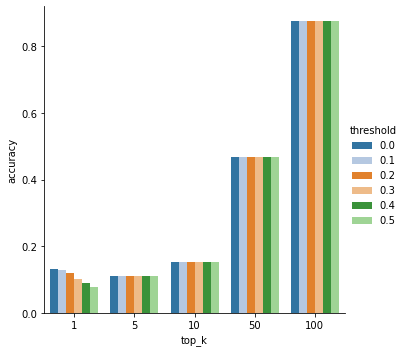

In [40]:
sns.catplot(data=topk_df[topk_df["model"]=="RN50"],x="top_k",y="accuracy",kind="bar",hue="threshold",palette="tab20")

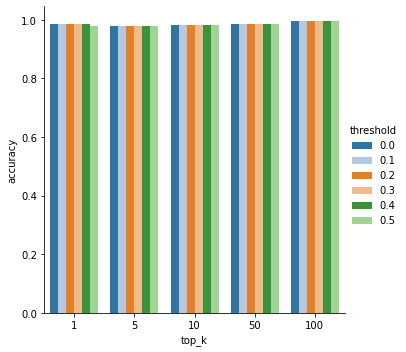

In [39]:
sns.catplot(data=topk_df[topk_df["model"]=="RN50_trained"],x="top_k",y="accuracy",kind="bar",hue="threshold",palette="tab20")